In [1]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

import config as CFG
from models import *
from dataset import *
import scanpy as sc
from torch.utils.data import DataLoader

import os
import numpy as np
import pandas as pd

import scanpy as sc
from itertools import chain

In [2]:
#print the current scanpy version
print(sc.__version__)

1.9.2


In [3]:
fold=5
data='her2st' #### Change here to test different dataset 'her2st' 'cscc'

prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

def pk_load(fold,mode='test',flatten=False,dataset='her2st',r=4,ori=True,adj=True,prune='Grid',neighs=8): #r=4 Hist2ST
    assert dataset in ['her2st','cscc']
    if dataset=='her2st':
        dataset = CLIP_HER2ST(
            train=(mode=='train'),fold=fold,flatten=flatten,
            ori=ori,neighs=neighs,adj=adj,prune=prune,r=r
        )
    elif dataset=='cscc':
        dataset = CLIP_SKIN(
            train=(mode=='train'),fold=fold,flatten=flatten,
            ori=ori,neighs=neighs,adj=adj,prune=prune,r=r
        )
    return dataset

def build_loaders_inference():
    print("Building loaders")
    trainset = pk_load(fold,'train',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    train_loader = DataLoader(trainset, batch_size=1, num_workers=0, shuffle=True)
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    print("Finished building loaders")
    return trainset, testset, train_loader, test_loader

#2265x256, 2277x256
def find_matches(spot_embeddings, query_embeddings, top_k=1):
    #find the closest matches 
    spot_embeddings = torch.tensor(spot_embeddings)
    query_embeddings = torch.tensor(query_embeddings)
    query_embeddings = F.normalize(query_embeddings, p=2, dim=-1)
    spot_embeddings = F.normalize(spot_embeddings, p=2, dim=-1)
    dot_similarity = query_embeddings @ spot_embeddings.T   #2277x2265
    print(dot_similarity.shape)
    _, indices = torch.topk(dot_similarity.squeeze(0), k=top_k)
    
    return indices.cpu().numpy()

In [4]:
### Loading data

trainset, testset, train_loader, test_loader = build_loaders_inference()
train_loader = chain(train_loader, test_loader)

print("Finished loading data")

Building loaders
Test set names: ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G2', 'H1']
Train set names: ['D6', 'H3', 'A4', 'B2', 'A5', 'D4', 'H2', 'C5', 'D3', 'D5', 'A2', 'G3', 'E2', 'F3', 'F2', 'A6', 'B5', 'E3', 'B4', 'C2', 'B3', 'G1', 'C6', 'D2', 'C4', 'C3', 'A3', 'B6']
Loading imgs...


Loading metadata...
Test set names: ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G2', 'H1']
Train set names: ['D6', 'H3', 'A4', 'B2', 'A5', 'D4', 'H2', 'C5', 'D3', 'D5', 'A2', 'G3', 'E2', 'F3', 'F2', 'A6', 'B5', 'E3', 'B4', 'C2', 'B3', 'G1', 'C6', 'D2', 'C4', 'C3', 'A3', 'B6']
Loading imgs...
Loading metadata...
Finished building loaders
Finished loading data


In [5]:

# model_path ="clip/best.pt"
model_path ="clip/ICL2ST_HER2.pt"
# model_path ="clip/ICL2ST_cSCC.pt"
save_path = "clip/embeddings/"
model = myModel().cuda()

state_dict = torch.load(model_path)
new_state_dict = {}
for key in state_dict.keys():
    new_key = key.replace('module.', '')  # remove the prefix 'module.'
    new_key = new_key.replace('well', 'spot') # for compatibility with prior naming
    if "image_encoder.gnn" in new_key: # Special to GNN because GNN use torch_geometric.nn
        new_key = new_key.replace("module_1.","module_1.module.")  
    new_state_dict[new_key] = state_dict[key]

model.load_state_dict(new_state_dict)
model.eval()

print("Finished loading model")

Finished loading model


In [6]:
if not os.path.exists(save_path):
        os.makedirs(save_path)
        
adj_dict = {}
exp_dict = {}
center_dict = {}
with torch.no_grad():
    for batch in tqdm(train_loader):
        ID, patch, center, exp, adj, oris, sfs, centers = batch
        print("Processing image ", ID)
        B,N,C,H,W = patch.shape
        patch = patch.reshape(B*N,C,H,W)  # (N,3,112,112)
        if adj.dim() == 3:
            adj = adj.squeeze(0)
        if exp.dim() == 3:
            exp = exp.squeeze(0)
            centers = centers.squeeze().numpy()
        adj_dict[ID] = adj 
        exp_dict[ID] = exp 
        center_dict[ID] = centers
        
        image_features = model.image_encoder(patch.cuda())
        spot_features = model.spot_encoder(exp.cuda(), adj.cuda())
        
        image_embeddings = model.image_projection(image_features).cpu().numpy()
        spot_embeddings = (model.spot_projection(spot_features.cuda()))
        
        spot_encoding = model.spot_autoencoder.encode(spot_embeddings, adj.cuda())
        spot_reconstruction, extra = model.spot_autoencoder.decode(spot_encoding.cuda())
        
        spot_embeddings = spot_embeddings.cpu().numpy()
        spot_encoding = spot_encoding.cpu().numpy()
        spot_reconstruction = spot_reconstruction.cpu().numpy()
        
        # print(image_embeddings.shape)
        # print(spot_embeddings.shape)
        np.save(save_path + "img_embeddings_" + str(ID[0]) + ".npy", image_embeddings.T)
        np.save(save_path + "spot_embeddings_" + str(ID[0]) + ".npy", spot_embeddings.T)

0it [00:00, ?it/s]

Processing image  ('A2',)


2it [00:02,  1.11s/it]

Processing image  ('B2',)


3it [00:02,  1.40it/s]

Processing image  ('G3',)


4it [00:03,  1.98it/s]

Processing image  ('B4',)


5it [00:03,  2.20it/s]

Processing image  ('F2',)


6it [00:03,  2.83it/s]

Processing image  ('A5',)


7it [00:03,  3.07it/s]

Processing image  ('E3',)


8it [00:04,  3.51it/s]

Processing image  ('D5',)


10it [00:04,  4.33it/s]

Processing image  ('E2',)
Processing image  ('C2',)


11it [00:04,  4.72it/s]

Processing image  ('D3',)
Processing image  ('D2',)


14it [00:04,  6.26it/s]

Processing image  ('C3',)
Processing image  ('B6',)


15it [00:05,  4.63it/s]

Processing image  ('F3',)


17it [00:05,  5.81it/s]

Processing image  ('B3',)
Processing image  ('C5',)


19it [00:05,  6.66it/s]

Processing image  ('C6',)
Processing image  ('D4',)


20it [00:06,  5.36it/s]

Processing image  ('H2',)
Processing image  ('D6',)


22it [00:06,  4.78it/s]

Processing image  ('G1',)
Processing image  ('A4',)


24it [00:06,  5.44it/s]

Processing image  ('A3',)
Processing image  ('A6',)


26it [00:07,  6.25it/s]

Processing image  ('C4',)
Processing image  ('B5',)


28it [00:07,  4.93it/s]

Processing image  ('H3',)


29it [00:07,  4.44it/s]

Processing image  ('A1',)
Processing image  ('B1',)


31it [00:08,  5.70it/s]

Processing image  ('C1',)
Processing image  ('D1',)


33it [00:08,  4.69it/s]

Processing image  ('E1',)


34it [00:09,  3.97it/s]

Processing image  ('F1',)


35it [00:09,  3.99it/s]

Processing image  ('G2',)


36it [00:09,  3.75it/s]

Processing image  ('H1',)


In [10]:
save_path = "clip/embeddings/"
all_files = os.listdir(save_path)

# exp_dict = {}
# for batch in tqdm(train_loader):
#     ID, patch, center, exp, adj, oris, sfs, *_ = batch
#     print(ID)
#     print(exp.shape)
#     exp_dict[ID] = exp  # Assuming ID and exp are tensors, we fetch their first elements

image_embeddings_dict = {}
spot_embeddings_dict = {}
ID_list = []

for file in all_files:
    if file.endswith(".npy"):
        # Extract the ID from the filename (e.g., A2, C3, etc.)
        if data=='her2st': 
            if 'rep' not in file:
                ID = file.split("_")[2].split(".")[0]
        elif data=='cscc':
            if 'rep' in file:
                ID = "_".join(file.split("_")[2:-1]) + "_" + file.split("_")[-1].split(".")[0]
        
        if (ID,) in adj_dict:
            adj_dict[ID] = adj_dict.pop((ID,))
        if (ID,) in exp_dict:
            exp_dict[ID] = exp_dict.pop((ID,))
        if (ID,) in center_dict:
            center_dict[ID] = center_dict.pop((ID,))
            
        # Determine the type of file based on its prefix and load the data
        if "img_embeddings" in file:
            image_embeddings_dict[ID] = np.load(os.path.join(save_path, file))
            ID_list.append(ID)
        elif "spot_embeddings" in file:
            spot_embeddings_dict[ID] = np.load(os.path.join(save_path, file))

# Now, image_embeddings_dict and spot_embeddings_dict contain the required data
print(image_embeddings_dict.keys())  # Should list all the image embedding IDs
print(spot_embeddings_dict.keys())  # Should list all the spot embedding IDs
print(exp_dict.keys())  # Should list all the spot embedding IDs
print(ID_list)

if data=='her2st':   
    fold=[0,6,12,18,24,27,31,33]
    test_ID = ['A1','B1','C1','D1','E1','F1','G2','H1']
elif data=='cscc':
    fold=[0,3,6,9]
    test_ID = ['P2_ST_rep1', 'P5_ST_rep1', 'P9_ST_rep1', 'P10_ST_rep1']
    
# test_ID = [ID_list[i] for i in fold]
print("Test set names:", test_ID)
train_ID = list(set(ID_list)-set(test_ID))
print("Train set names:",train_ID)



dict_keys(['H1', 'A2', 'B2', 'G3', 'B4', 'F2', 'A5', 'E3', 'D5', 'E2', 'C2', 'D3', 'D2', 'C3', 'B6', 'F3', 'B3', 'C5', 'C6', 'D4', 'H2', 'D6', 'G1', 'A4', 'A3', 'A6', 'C4', 'B5', 'H3', 'A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G2'])
dict_keys(['H1', 'A2', 'B2', 'G3', 'B4', 'F2', 'A5', 'E3', 'D5', 'E2', 'C2', 'D3', 'D2', 'C3', 'B6', 'F3', 'B3', 'C5', 'C6', 'D4', 'H2', 'D6', 'G1', 'A4', 'A3', 'A6', 'C4', 'B5', 'H3', 'A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G2'])
dict_keys(['A2', 'B2', 'G3', 'B4', 'F2', 'A5', 'E3', 'D5', 'E2', 'C2', 'D3', 'D2', 'C3', 'B6', 'F3', 'B3', 'C5', 'C6', 'D4', 'H2', 'D6', 'G1', 'A4', 'A3', 'A6', 'C4', 'B5', 'H3', 'A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G2', 'H1'])
['H1', 'H1', 'H1', 'H1', 'H1', 'H1', 'H1', 'H1', 'H1', 'H1', 'H1', 'H1', 'A2', 'B2', 'G3', 'B4', 'F2', 'A5', 'E3', 'D5', 'E2', 'C2', 'D3', 'D2', 'C3', 'B6', 'F3', 'B3', 'C5', 'C6', 'D4', 'H2', 'D6', 'G1', 'A4', 'A3', 'A6', 'C4', 'B5', 'H3', 'A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G2', 'H1']
Test set names: ['A1', 'B1'

In [11]:
#query
# test_ID.remove('A1')
print(test_ID)
# image_query = [spot_embeddings_dict[ID] for ID in test_ID]
# expression_gt = [exp_dict[ID].numpy().T for ID in test_ID]

# image_train_data = [image_embeddings_dict[ID] for ID in train_ID]
spot_train_data = [spot_embeddings_dict[ID] for ID in train_ID]
expression_train_data = [exp_dict[ID].numpy().T for ID in train_ID]

spot_key = np.concatenate(spot_train_data, axis=1)
expression_key = np.concatenate(expression_train_data, axis=1)

# print(image_query.shape)
# print(expression_gt.shape)
print(spot_key.shape)
print(expression_key.shape)

if spot_key.shape[1] != 256:
    spot_key = spot_key.T
    print("spot_key shape: ", spot_key.shape)
if expression_key.shape[0] != spot_key.shape[0]:
    expression_key = expression_key.T
    print("expression_key shape: ", expression_key.shape)

['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G2', 'H1']
(256, 10139)
(785, 10139)
spot_key shape:  (10139, 256)
expression_key shape:  (10139, 785)


In [13]:
import torch
import numpy as np
import scanpy as sc
import anndata as ad
from tqdm import tqdm
from scipy.stats import pearsonr,spearmanr
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

def test(model,test,device='cuda'):
    model=model.to(device)
    model.eval()
    preds=None
    ct=None
    gt=None
    loss=0
    with torch.no_grad():
        for patch, position, exp, adj, *_, center in tqdm(test):
            patch, position, adj = patch.to(device), position.to(device), adj.to(device).squeeze(0)
            pred = model(patch, position, adj)[0]
            preds = pred.squeeze().cpu().numpy()
            ct = center.squeeze().cpu().numpy()
            gt = exp.squeeze().cpu().numpy()
    adata = ad.AnnData(preds)
    adata.obsm['spatial'] = ct
    adata_gt = ad.AnnData(gt)
    adata_gt.obsm['spatial'] = ct
    return adata,adata_gt

def cluster(adata,label):
    idx = label != 'undetermined'
    tmp=adata[idx]
    l=label[idx]
    print("cluster number:",len(set(l)))
    sc.pp.pca(tmp)
    sc.tl.tsne(tmp)
    kmeans = KMeans(n_clusters=len(set(l)), init="k-means++", random_state=0).fit(tmp.obsm['X_pca'])
    p=kmeans.labels_.astype(str)
    lbl=np.full(len(adata),str(len(set(l))))
    lbl[idx]=p
    adata.obs['kmeans']=lbl
    return p,round(ari_score(p,l),3)

def get_R(data1,data2,dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X
    r1,p1=[],[]
    for g in range(data1.shape[dim]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g])
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:])
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_top_values(arr, num_top_values=10, lowest=False):
    return sorted([(i, arr[i]) for i in range(len(arr))], key=lambda x: x[1], reverse=not lowest)[:num_top_values]
top_k = 50
results = {}
top_results = {}
selected_folds = [5]



Processing Image A1
image query shape:  (346, 256)
expression_gt shape:  (346, 785)
finding matches, using weighted average of top 50 expressions
torch.Size([346, 10139])
(346, 785)
(346, 785)
3.0622825622558594
3.5403168
0.0
0.0
The Prediction: prediction
Mean correlation across cells:  0.5604443326487737
MSE across cells:  0.3341141738866571
RMSE across cells:  0.5780261013887323


/tmp/ipykernel_1517/1626810633.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_embeddings = model.spot_projection(torch.tensor(pred_features, dtype=torch.float32).cuda())
/tmp/ipykernel_1517/1626810633.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_encoding = model.spot_autoencoder.encode(torch.tensor(pred_embeddings, dtype=torch.float32).cuda(), adj.cuda())
/tmp/ipykernel_1517/1626810633.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_reconstruction, extra = model.spot_autoencoder.decode(torch.tensor(pred_e

Max correlation across genes: 0.686215330499687
Fold A1 mean correlation across genes:  0.21650806575246917
Fold A1 number of genes with correlation > 0.3:  181
Fold A1 :Top 50 Genes Mean Pearson Correlation: 0.46753011049729154
Fold A1 Top 10 genes with highest correlation:
Gene ID: 154, Gene Name: MUCL1, R: 0.686215330499687
Gene ID: 227, Gene Name: SCD, R: 0.6342965894397874
Gene ID: 60, Gene Name: IGKC, R: 0.572499681032992
Gene ID: 698, Gene Name: HLA-DRA, R: 0.56902338916107
Gene ID: 366, Gene Name: FASN, R: 0.5665180846553283
Gene ID: 397, Gene Name: IGFBP2, R: 0.5544618700509107
Gene ID: 71, Gene Name: COMP, R: 0.5331399071017923
Gene ID: 495, Gene Name: FN1, R: 0.5251849681330875
Gene ID: 447, Gene Name: IGHG3, R: 0.5224528499545996
Gene ID: 217, Gene Name: JCHAIN, R: 0.5183682643653352
cluster number: 5
Fold: [0, 6, 12, 18, 24, 27, 31, 33] ARI: 0.057


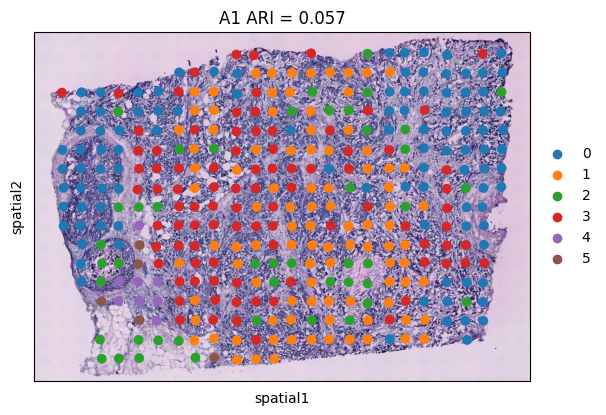

cluster number: 5


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression features ARI: 0.176
cluster number: 5


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression Embeddings ARI: 0.186
cluster number: 5


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Reconstruction ARI: 0.006
cluster number: 5


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Mixed Reconstruction ARI: 0.067
Processing Image B1
image query shape:  (295, 256)
expression_gt shape:  (295, 785)
finding matches, using weighted average of top 50 expressions
torch.Size([295, 10139])
(295, 785)
(295, 785)
3.0228309631347656
3.494989
0.0
0.0
The Prediction: prediction
Mean correlation across cells:  0.569587063784764
MSE across cells:  0.2545466931481575
RMSE across cells:  0.5045262066019539


/tmp/ipykernel_1517/1626810633.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_embeddings = model.spot_projection(torch.tensor(pred_features, dtype=torch.float32).cuda())
/tmp/ipykernel_1517/1626810633.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_encoding = model.spot_autoencoder.encode(torch.tensor(pred_embeddings, dtype=torch.float32).cuda(), adj.cuda())
/tmp/ipykernel_1517/1626810633.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_reconstruction, extra = model.spot_autoencoder.decode(torch.tensor(pred_e

Max correlation across genes: 0.7354946822293463
Fold B1 mean correlation across genes:  0.3607857592387748
Fold B1 number of genes with correlation > 0.3:  523
Fold B1 :Top 50 Genes Mean Pearson Correlation: 0.6169305974142767
Fold B1 Top 10 genes with highest correlation:
Gene ID: 495, Gene Name: FN1, R: 0.7354946822293463
Gene ID: 698, Gene Name: HLA-DRA, R: 0.6953279428528785
Gene ID: 197, Gene Name: HLA-B, R: 0.6915786145676555
Gene ID: 227, Gene Name: SCD, R: 0.6912442570273116
Gene ID: 704, Gene Name: STMN1, R: 0.6828778670425082
Gene ID: 715, Gene Name: IGLC3, R: 0.6708664618076201
Gene ID: 134, Gene Name: GNAS, R: 0.6597485692701951
Gene ID: 582, Gene Name: NDUFB3, R: 0.6501795912921897
Gene ID: 733, Gene Name: UBA52, R: 0.6479987745049777
Gene ID: 563, Gene Name: CXCL10, R: 0.6451278287422336
cluster number: 4
Fold: [0, 6, 12, 18, 24, 27, 31, 33] ARI: 0.286


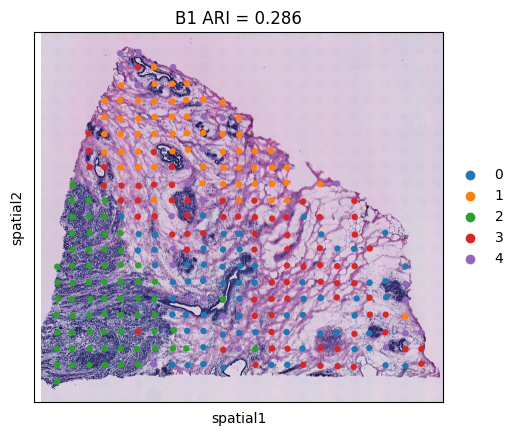

cluster number: 4


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression features ARI: 0.251
cluster number: 4


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression Embeddings ARI: 0.285
cluster number: 4


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Reconstruction ARI: 0.282
cluster number: 4


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Mixed Reconstruction ARI: 0.281
Processing Image C1
image query shape:  (176, 256)
expression_gt shape:  (176, 785)
finding matches, using weighted average of top 50 expressions
torch.Size([176, 10139])
(176, 785)
(176, 785)
3.2418301105499268
3.4836807
0.0
0.0
The Prediction: prediction
Mean correlation across cells:  0.6840485194996494
MSE across cells:  0.20603291454227574
RMSE across cells:  0.45390848696876746
Max correlation across genes: 0.890450910678685
Fold C1 mean correlation across genes:  0.33043779865371864
Fold C1 number of genes with correlation > 0.3:  460
Fold C1 :Top 50 Genes Mean Pearson Correlation: 0.6405365438992986
Fold C1 Top 10 genes with highest correlation:
Gene ID: 60, Gene Name: IGKC, R: 0.890450910678685
Gene ID: 507, Gene Name: IGLC2, R: 0.8485438225384633
Gene ID: 328, Gene Name: MGP, R: 0.846226827352047
Gene ID: 154, Gene Name: MUCL1, R: 0.7878907660105765
Gene ID: 227, Gene Name: SCD, R: 0.7837410579457176
Gene ID

/tmp/ipykernel_1517/1626810633.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_embeddings = model.spot_projection(torch.tensor(pred_features, dtype=torch.float32).cuda())
/tmp/ipykernel_1517/1626810633.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_encoding = model.spot_autoencoder.encode(torch.tensor(pred_embeddings, dtype=torch.float32).cuda(), adj.cuda())
/tmp/ipykernel_1517/1626810633.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_reconstruction, extra = model.spot_autoencoder.decode(torch.tensor(pred_e

Fold: [0, 6, 12, 18, 24, 27, 31, 33] ARI: 0.108


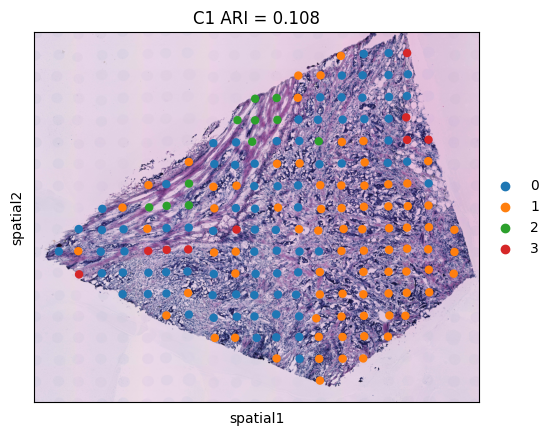

cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression features ARI: 0.027
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression Embeddings ARI: 0.114
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Reconstruction ARI: 0.109
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Mixed Reconstruction ARI: 0.142
Processing Image D1
image query shape:  (306, 256)
expression_gt shape:  (306, 785)
finding matches, using weighted average of top 50 expressions
torch.Size([306, 10139])
(306, 785)
(306, 785)
2.675163507461548
3.1218235
0.0
0.0
The Prediction: prediction
Mean correlation across cells:  0.6808900078915069
MSE across cells:  0.24215084571406076
RMSE across cells:  0.4920882499248085
Max correlation across genes: 0.7677479684608258
Fold D1 mean correlation across genes:  0.253540939357217
Fold D1 number of genes with correlation > 0.3:  215
Fold D1 :Top 50 Genes Mean Pearson Correlation: 0.5022487720309625
Fold D1 Top 10 genes with highest correlation:
Gene ID: 495, Gene Name: FN1, R: 0.7677479684608258
Gene ID: 89, Gene Name: ITGB6, R: 0.6518177487783122
Gene ID: 60, Gene Name: IGKC, R: 0.6438648235910955
Gene ID: 275, Gene Name: C3, R: 0.6358662195658035
Gene ID: 507, Gene Name: IGLC2, R: 0.5809223471051755
Gene ID: 2

/tmp/ipykernel_1517/1626810633.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_embeddings = model.spot_projection(torch.tensor(pred_features, dtype=torch.float32).cuda())
/tmp/ipykernel_1517/1626810633.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_encoding = model.spot_autoencoder.encode(torch.tensor(pred_embeddings, dtype=torch.float32).cuda(), adj.cuda())
/tmp/ipykernel_1517/1626810633.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_reconstruction, extra = model.spot_autoencoder.decode(torch.tensor(pred_e

Fold: [0, 6, 12, 18, 24, 27, 31, 33] ARI: 0.286


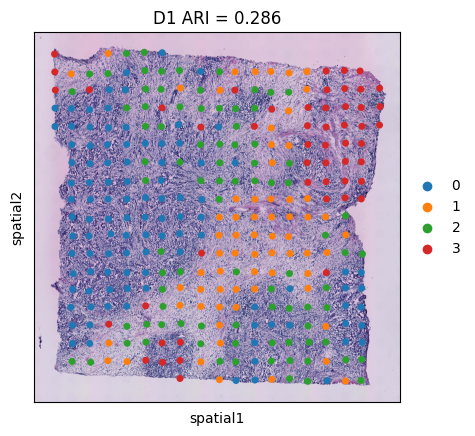

cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression features ARI: 0.011
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression Embeddings ARI: 0.323
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Reconstruction ARI: 0.178
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Mixed Reconstruction ARI: 0.286
Processing Image E1
image query shape:  (587, 256)
expression_gt shape:  (587, 785)
finding matches, using weighted average of top 50 expressions
torch.Size([587, 10139])


/tmp/ipykernel_1517/1626810633.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_embeddings = model.spot_projection(torch.tensor(pred_features, dtype=torch.float32).cuda())
/tmp/ipykernel_1517/1626810633.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_encoding = model.spot_autoencoder.encode(torch.tensor(pred_embeddings, dtype=torch.float32).cuda(), adj.cuda())
/tmp/ipykernel_1517/1626810633.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_reconstruction, extra = model.spot_autoencoder.decode(torch.tensor(pred_e

(587, 785)
(587, 785)
3.283313751220703
3.4946344
0.0
0.0
The Prediction: prediction
Mean correlation across cells:  0.7161696515648726
MSE across cells:  0.17064421076179373
RMSE across cells:  0.4130910441558782
Max correlation across genes: 0.5855379723034757
Fold E1 mean correlation across genes:  0.19058990568004827
Fold E1 number of genes with correlation > 0.3:  147
Fold E1 :Top 50 Genes Mean Pearson Correlation: 0.4224108071846526
Fold E1 Top 10 genes with highest correlation:
Gene ID: 447, Gene Name: IGHG3, R: 0.5855379723034757
Gene ID: 311, Gene Name: IGHA1, R: 0.5604006083616653
Gene ID: 154, Gene Name: MUCL1, R: 0.5551540595658769
Gene ID: 134, Gene Name: GNAS, R: 0.5409671600427285
Gene ID: 366, Gene Name: FASN, R: 0.5337314456680206
Gene ID: 507, Gene Name: IGLC2, R: 0.5005244678362346
Gene ID: 495, Gene Name: FN1, R: 0.49896907880081304
Gene ID: 765, Gene Name: LTF, R: 0.4956001738016602
Gene ID: 431, Gene Name: CLDN4, R: 0.4930620229655661
Gene ID: 113, Gene Name: FDPS

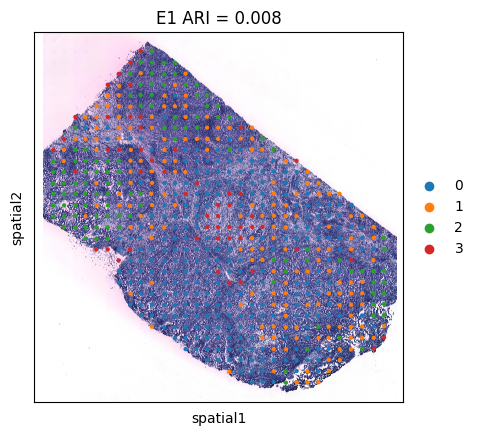

cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression features ARI: 0.005
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression Embeddings ARI: -0.01
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Reconstruction ARI: -0.007
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Mixed Reconstruction ARI: 0.005
Processing Image F1
image query shape:  (691, 256)
expression_gt shape:  (691, 785)
finding matches, using weighted average of top 50 expressions
torch.Size([691, 10139])


/tmp/ipykernel_1517/1626810633.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_embeddings = model.spot_projection(torch.tensor(pred_features, dtype=torch.float32).cuda())
/tmp/ipykernel_1517/1626810633.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_encoding = model.spot_autoencoder.encode(torch.tensor(pred_embeddings, dtype=torch.float32).cuda(), adj.cuda())
/tmp/ipykernel_1517/1626810633.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_reconstruction, extra = model.spot_autoencoder.decode(torch.tensor(pred_e

(691, 785)
(691, 785)
3.2022922039031982
3.5189433
0.0
0.0
The Prediction: prediction
Mean correlation across cells:  0.6456233616894616
MSE across cells:  0.27555567013154525
RMSE across cells:  0.524933967401182
Max correlation across genes: 0.5953708643364533
Fold F1 mean correlation across genes:  0.19701359272453178
Fold F1 number of genes with correlation > 0.3:  142
Fold F1 :Top 50 Genes Mean Pearson Correlation: 0.37505795899559763
Fold F1 Top 10 genes with highest correlation:
Gene ID: 60, Gene Name: IGKC, R: 0.5953708643364533
Gene ID: 636, Gene Name: LUC7L3, R: 0.43216388539910955
Gene ID: 495, Gene Name: FN1, R: 0.4320690728867184
Gene ID: 227, Gene Name: SCD, R: 0.4260879249862994
Gene ID: 507, Gene Name: IGLC2, R: 0.42198597557730305
Gene ID: 708, Gene Name: MYL9, R: 0.4159660775337396
Gene ID: 202, Gene Name: PTGDS, R: 0.4148702463679457
Gene ID: 580, Gene Name: TMBIM6, R: 0.4128522472144565
Gene ID: 134, Gene Name: GNAS, R: 0.41246841966838127
Gene ID: 368, Gene Name: R

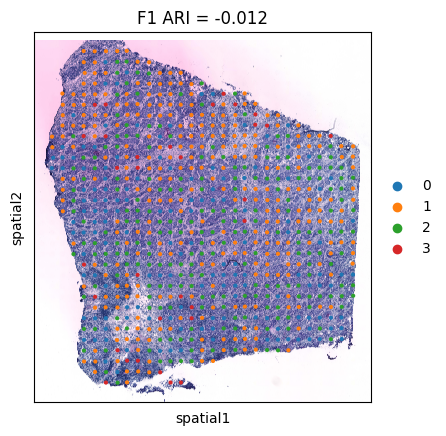

cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression features ARI: 0.001
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression Embeddings ARI: 0.001
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Reconstruction ARI: -0.007
cluster number: 3


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Mixed Reconstruction ARI: -0.012
Processing Image G2
image query shape:  (467, 256)
expression_gt shape:  (467, 785)
finding matches, using weighted average of top 50 expressions
torch.Size([467, 10139])
(467, 785)
(467, 785)
3.1883325576782227
3.564969
0.0
0.0
The Prediction: prediction


/tmp/ipykernel_1517/1626810633.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_embeddings = model.spot_projection(torch.tensor(pred_features, dtype=torch.float32).cuda())
/tmp/ipykernel_1517/1626810633.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_encoding = model.spot_autoencoder.encode(torch.tensor(pred_embeddings, dtype=torch.float32).cuda(), adj.cuda())
/tmp/ipykernel_1517/1626810633.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_reconstruction, extra = model.spot_autoencoder.decode(torch.tensor(pred_e

Mean correlation across cells:  0.6117426915360943
MSE across cells:  0.2718192141902508
RMSE across cells:  0.5213628431239138
Max correlation across genes: 0.6669315214606307
Fold G2 mean correlation across genes:  0.23520640101163903
Fold G2 number of genes with correlation > 0.3:  203
Fold G2 :Top 50 Genes Mean Pearson Correlation: 0.489812131428214
Fold G2 Top 10 genes with highest correlation:
Gene ID: 495, Gene Name: FN1, R: 0.6669315214606307
Gene ID: 134, Gene Name: GNAS, R: 0.6006086896745322
Gene ID: 78, Gene Name: TMEM123, R: 0.5905710215002715
Gene ID: 89, Gene Name: ITGB6, R: 0.5817698280929956
Gene ID: 87, Gene Name: FAM193B, R: 0.5654052684798604
Gene ID: 17, Gene Name: POSTN, R: 0.5630333877700199
Gene ID: 648, Gene Name: LUM, R: 0.5544092835386808
Gene ID: 746, Gene Name: MYL12B, R: 0.5512865291507396
Gene ID: 201, Gene Name: VIM, R: 0.5500093564692
Gene ID: 561, Gene Name: COL3A1, R: 0.5465931474514594
cluster number: 6
Fold: [0, 6, 12, 18, 24, 27, 31, 33] ARI: 0.172

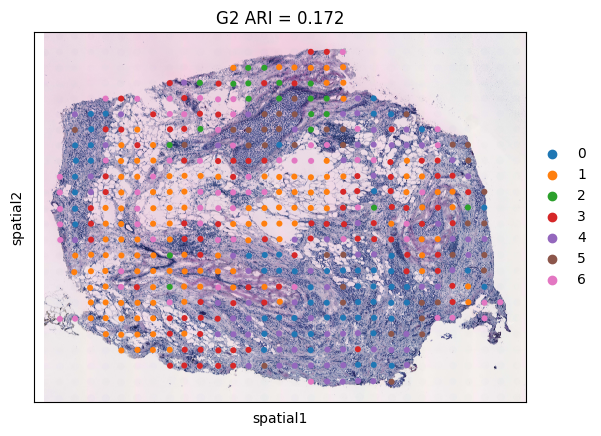

cluster number: 6


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression features ARI: 0.149
cluster number: 6


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression Embeddings ARI: 0.2
cluster number: 6


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Reconstruction ARI: 0.133
cluster number: 6


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Mixed Reconstruction ARI: 0.184
Processing Image H1
image query shape:  (613, 256)
expression_gt shape:  (613, 785)
finding matches, using weighted average of top 50 expressions
torch.Size([613, 10139])


/tmp/ipykernel_1517/1626810633.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_embeddings = model.spot_projection(torch.tensor(pred_features, dtype=torch.float32).cuda())
/tmp/ipykernel_1517/1626810633.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_encoding = model.spot_autoencoder.encode(torch.tensor(pred_embeddings, dtype=torch.float32).cuda(), adj.cuda())
/tmp/ipykernel_1517/1626810633.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_reconstruction, extra = model.spot_autoencoder.decode(torch.tensor(pred_e

(613, 785)
(613, 785)
3.312788486480713
3.5241778
0.0
0.0
The Prediction: prediction
Mean correlation across cells:  0.6562357939366277
MSE across cells:  0.20087995485554325
RMSE across cells:  0.44819633516523005
Max correlation across genes: 0.6238383690133503
Fold H1 mean correlation across genes:  0.2189262550614737
Fold H1 number of genes with correlation > 0.3:  176
Fold H1 :Top 50 Genes Mean Pearson Correlation: 0.45302323592988103
Fold H1 Top 10 genes with highest correlation:
Gene ID: 311, Gene Name: IGHA1, R: 0.6238383690133503
Gene ID: 60, Gene Name: IGKC, R: 0.5854707642557815
Gene ID: 698, Gene Name: HLA-DRA, R: 0.5574709826598337
Gene ID: 201, Gene Name: VIM, R: 0.5310496093688525
Gene ID: 134, Gene Name: GNAS, R: 0.5245591871130791
Gene ID: 758, Gene Name: HLA-DRB1, R: 0.5220467717469808
Gene ID: 388, Gene Name: A2M, R: 0.5184465105942735
Gene ID: 89, Gene Name: ITGB6, R: 0.5025520890495674
Gene ID: 197, Gene Name: HLA-B, R: 0.493909609254654
Gene ID: 346, Gene Name: GP

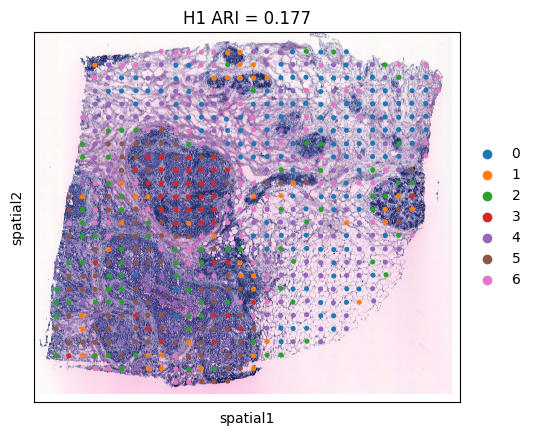

cluster number: 6


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression features ARI: 0.16
cluster number: 6


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Expression Embeddings ARI: 0.261
cluster number: 6


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Reconstruction ARI: 0.168
cluster number: 6


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Fold: [0, 6, 12, 18, 24, 27, 31, 33] Mixed Reconstruction ARI: 0.213


In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

for ID in test_ID:    
    print("Processing Image", ID)
    image_query = spot_embeddings_dict[ID]
    expression_gt = exp_dict[ID].numpy().T

    method = "weighted_average" # "average" "weighted_average"
    save_path = ""
    if image_query.shape[1] != 256:
        image_query = image_query.T
        print("image query shape: ", image_query.shape)
    if expression_gt.shape[0] != image_query.shape[0]:
        expression_gt = expression_gt.T
        print("expression_gt shape: ", expression_gt.shape)
    if spot_key.shape[1] != 256:
        spot_key = spot_key.T
        print("spot_key shape: ", spot_key.shape)
    if expression_key.shape[0] != spot_key.shape[0]:
        expression_key = expression_key.T
        print("expression_key shape: ", expression_key.shape)

    if method == "simple":
        indices = find_matches(spot_key, image_query, top_k=1)
        matched_spot_embeddings_pred = spot_key[indices[:,0],:]
        print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
        matched_spot_expression_pred = expression_key[indices[:,0],:]
        print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)

    if method == "average":
        print("finding matches, using average of top 50 expressions")
        indices = find_matches(spot_key, image_query, top_k=50)
        matched_spot_embeddings_pred = np.zeros((indices.shape[0], spot_key.shape[1]))
        matched_spot_expression_pred = np.zeros((indices.shape[0], expression_key.shape[1]))
        for i in range(indices.shape[0]):
            matched_spot_embeddings_pred[i,:] = np.average(spot_key[indices[i,:],:], axis=0)
            matched_spot_expression_pred[i,:] = np.average(expression_key[indices[i,:],:], axis=0)
        
        print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
        print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)

    if method == "weighted_average":
        print("finding matches, using weighted average of top 50 expressions")
        indices = find_matches(spot_key, image_query, top_k=100)
        # print("indices = ", indices)
        matched_spot_embeddings_pred = np.zeros((indices.shape[0], spot_key.shape[1]))
        matched_spot_expression_pred = np.zeros((indices.shape[0], expression_key.shape[1]))
        for i in range(indices.shape[0]):
            a = np.sum((spot_key[indices[i,0],:] - image_query[i,:])**2) #the smallest MSE
            weights = np.exp(-(np.sum((spot_key[indices[i,:],:] - image_query[i,:])**2, axis=1)-a+1))
            # weights = a/np.sum((spot_key[indices[i,:],:] - image_query[i,:])**2, axis=1)
            # a = np.sqrt(np.sum((spot_key[indices[i,0],:] - image_query[i,:])**2)) #the smallest RMSE
            # weights = np.exp(-(np.sqrt(np.sum((spot_key[indices[i,:],:] - image_query[i,:])**2, axis=1))-a+1))
            
            # sorted_indices = np.argsort(weights)[::-1]  # 
            # top_10_weights = weights[sorted_indices[:10]]
            # least_10_weights = weights[sorted_indices[-10:]]
            # print("Top 10 weights: ", top_10_weights)
            # print("least 10 weights: ", least_10_weights)
            
            # if i == 0:
            #     print("weights: ", weights)
            matched_spot_embeddings_pred[i,:] = np.average(spot_key[indices[i,:],:], axis=0, weights=weights)
            matched_spot_expression_pred[i,:] = np.average(expression_key[indices[i,:],:], axis=0, weights=weights)
        
        # print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
        # print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)

    true = expression_gt
    pred = matched_spot_expression_pred
    adj = adj_dict[ID]
    
    model.eval()
    
    # Create the directory if it doesn't exist
    output_dir = './figures/show'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    with torch.no_grad():
        pred_features = model.spot_encoder(torch.tensor(pred, dtype=torch.float32).cuda(), adj.cuda())
        pred_embeddings = model.spot_projection(torch.tensor(pred_features, dtype=torch.float32).cuda())
        pred_encoding = model.spot_autoencoder.encode(torch.tensor(pred_embeddings, dtype=torch.float32).cuda(), adj.cuda())
        pred_reconstruction, extra = model.spot_autoencoder.decode(torch.tensor(pred_encoding, dtype=torch.float32).cuda())

        pred_features = pred_features.cpu().numpy()
        pred_embeddings = pred_embeddings.cpu().numpy()
        pred_encoding = pred_encoding.cpu().numpy()
        pred_reconstruction = pred_reconstruction.cpu().numpy()

    print(pred.shape)
    print(true.shape)
    print(np.max(pred))
    print(np.max(true))
    print(np.min(pred))
    print(np.min(true))
    
    ####### Prediction PCC performance
    mix = (pred + pred_reconstruction)/2
    
    def evaluate_gene_expression(pred, true, ID, top_k, fold, top_results, testset):
        # Genewise correlation across cells
        corr_cells = np.zeros(pred.shape[0])
        for i in range(pred.shape[0]):
            corr_cells[i] = np.corrcoef(pred[i, :], true[i, :])[0, 1]
        # Remove NaN
        corr_cells = corr_cells[~np.isnan(corr_cells)]
        print("Mean correlation across cells: ", np.mean(corr_cells))
        
        # Calculate RMSE across cells
        mse_cells = mean_squared_error(pred, true)
        rmse_cells = sqrt(mse_cells)
        print("MSE across cells: ", mse_cells)
        print("RMSE across cells: ", rmse_cells)
        
        # Genewise correlation across genes
        corr_genes = np.zeros(pred.shape[1])
        for i in range(pred.shape[1]):
            corr_genes[i] = np.corrcoef(pred[:, i], true[:, i])[0, 1]
        # Remove NaN
        corr_genes = corr_genes[~np.isnan(corr_genes)]
        
        if corr_genes.size == 0:
            print("corr_genes is an empty array")
        elif np.isnan(corr_genes).all():
            print("corr_genes is an array of NaNs")
        else:
            print("Max correlation across genes:", np.nanmax(corr_genes))
        
        print('Fold', ID, "mean correlation across genes: ", np.mean(corr_genes))
        print('Fold', ID, "number of genes with correlation > 0.3: ", np.sum(corr_genes > 0.3))
        
        # Top-k genes
        top_k_indices = np.argsort(corr_genes)[-top_k:]
        top_R_values = corr_genes[top_k_indices]
        top_pred_values = pred[:, top_k_indices]
        top_results[ID] = (top_R_values, top_pred_values)
        print('Fold', ID, f':Top {top_k} Genes Mean Pearson Correlation:', np.nanmean(top_R_values))
        
        # Get top gene correlations
        top_R_values = get_top_values(corr_genes)
        print('Fold', ID, "Top 10 genes with highest correlation:")
        for gene_id, r_value in top_R_values:
            gene_name = testset.gene_set[gene_id]
            print(f"Gene ID: {gene_id}, Gene Name: {gene_name}, R: {r_value}")

    # Example usage:
    print(f"The Prediction: prediction")
    evaluate_gene_expression(pred, true, ID, top_k, fold, top_results, testset)
    # print(f"\n The Prediction Matrix: pred_reconstruction")
    # evaluate_gene_expression(pred_reconstruction, true, ID, top_k, fold, top_results, testset)
    # print(f"\n The Prediction Matrix: mix")
    # evaluate_gene_expression(mix, true, ID, top_k, fold, top_results, testset)
    
    ####### Clustering 
    ### Change the type of pred to AnnData for the next clustering task
    pred = sc.AnnData(pred)
    pred.obsm['spatial'] = center_dict[ID]
    true = ad.AnnData(true)
    true.obsm['spatial'] = center_dict[ID]
    pred_features = sc.AnnData(pred_features)
    pred_features.obsm['spatial'] = center_dict[ID]
    pred_embeddings = sc.AnnData(pred_embeddings)
    pred_embeddings.obsm['spatial'] = center_dict[ID]
    # pred_encoding = sc.AnnData(pred_encoding)
    # pred_encoding.obsm['spatial'] = center_dict[ID]
    pred_reconstruction = sc.AnnData(pred_reconstruction)
    pred_reconstruction.obsm['spatial'] = center_dict[ID]
    mix = sc.AnnData(mix)
    mix.obsm['spatial'] = center_dict[ID]

    if data=='her2st':
        ####### Generate cluster figure
        label = testset.label[ID]
        # print("label = ",label)
        clus, ARI = cluster(pred, label)
        print('Fold:', fold, 'ARI:', ARI)
        title = f"{ID} ARI = {ARI:.3f}"  # Format title with ARI value   
        sc.pl.spatial(pred, img=testset.get_img(ID), color='kmeans', spot_size=112, title=title, save=f"/mymodel_Her2_{ID}.pdf")    
        
        
        # clus, Top_ARI = cluster(top_pred_values, label)
        # print('Fold:', fold, 'Top 100 ARI:', Top_ARI)
        clus, feature_ARI = cluster(pred_features, label)
        print('Fold:', fold, 'Expression features ARI:', feature_ARI)
        # title = f"{ID} ARI = {ARI:.3f}"  # Format title with ARI value   
        # sc.pl.spatial(pred_features, img=testset.get_img(ID), color='kmeans', spot_size=112, title=title, save=f"/mymodel_Her2_{ID}_features.pdf")   
        
        clus, Emb_ARI = cluster(pred_embeddings, label)
        print('Fold:', fold, 'Expression Embeddings ARI:', Emb_ARI)
        # title = f"{ID} ARI = {Emb_ARI:.3f}"  # Format title with ARI value   
        # sc.pl.spatial(pred_embeddings, img=testset.get_img(ID), color='kmeans', spot_size=112, title = title, save=f"/mymodel_Her2_{ID}_Emb.pdf")

        
        clus, Re_ARI = cluster(pred_reconstruction, label)
        print('Fold:', fold, 'Reconstruction ARI:', Re_ARI)
        # title = f"{ID} ARI = {Re_ARI:.3f}"  # Format title with ARI value   
        # sc.pl.spatial(pred_reconstruction, img=testset.get_img(ID), color='kmeans', spot_size=112, title = title, save=f"/mymodel_Her2_{ID}_Reconstruction.pdf")    
        
        clus, mix_ARI = cluster(mix, label)
        print('Fold:', fold, 'Mixed Reconstruction ARI:', mix_ARI)
        # title = f"{ID} ARI = {mix_ARI:.3f}"  # Format title with ARI value   
        # sc.pl.spatial(mix, img=testset.get_img(ID), color='kmeans', spot_size=112, title = title, save=f"/mymodel_Her2_{ID}_mix.pdf") 

    
    # print("\n")
    # if save_path != "":
    #     np.save(save_path + "matched_spot_embeddings_pred.npy", matched_spot_embeddings_pred.T)
    #     np.save(save_path + "matched_spot_expression_pred.npy", matched_spot_expression_pred.T)



In [ ]:
print(pred.shape)
print(pred_features.shape)
print(pred_embeddings.shape)
print(pred_reconstruction.shape)

(613, 785)
(613, 785)
(613, 256)
(613, 785)
